In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data_path = "../data/"

## 1. 移動平均（時系列変動の平滑化）

In [5]:
df_historical = pd.read_csv(f"{data_path}m_quote.csv", encoding="shift-jis", header=1)
df_historical.head()

,Unnamed: 0,USD,GBP,EUR,CAD,CHF,SEK,DKK,NOK,AUD,...,HUF,CZK,PLN,TRY,IDR(100).1,CNY.1,MYR.1,KRW(100).1,TWD,RUB
0,2002/4/30,131.15,189.01,115.97,82.83,79.13,12.73,15.61,15.20,70.24,...,*****,*****,*****,NaN,1.39,15.84,*****,9.99,3.77,NaN
1,2002/5/31,126.44,184.56,115.88,81.58,79.60,12.57,15.59,15.43,69.58,...,*****,*****,*****,NaN,1.41,15.28,*****,10.10,3.68,NaN
2,2002/6/28,123.53,183.00,117.83,80.64,80.09,12.94,15.86,15.92,70.29,...,*****,*****,*****,NaN,1.44,14.93,*****,10.20,3.66,NaN
3,2002/7/31,118.05,183.64,117.23,76.52,80.16,12.67,15.79,15.83,65.42,...,*****,*****,*****,NaN,1.34,14.26,*****,9.98,3.56,NaN
4,2002/8/30,119.08,183.14,116.45,75.85,79.60,12.59,15.69,15.68,64.47,...,*****,*****,*****,NaN,1.35,14.39,*****,9.97,3.53,NaN


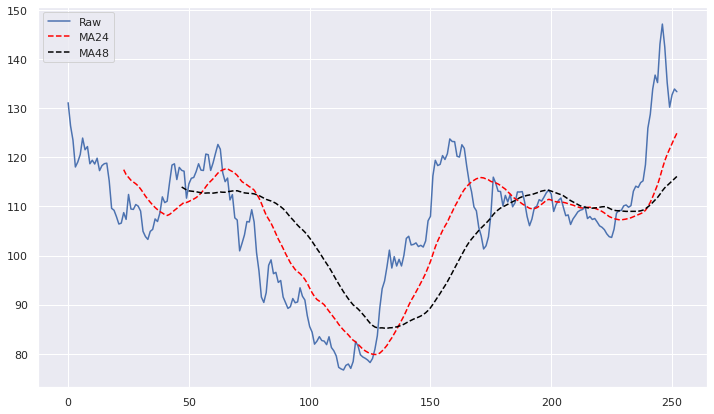

In [15]:
#  USDの結果をプロットする
plt.figure(figsize=(12, 7))
plt.plot(df_historical["USD"], label="Raw")
plt.plot(df_historical["USD"].rolling(24).mean(), label="MA24", linestyle="dashed", c="red")
plt.plot(df_historical["USD"].rolling(48).mean(), label="MA48", linestyle="dashed", c="black")
plt.legend()
plt.show()

## 2. 中心化移動平均

In [18]:
df_ice = pd.read_csv(f"{data_path}icecream.csv", encoding="shift-jis", header=1)
df_ice.rename(columns={
    "年":"year",
    "月":"month",
    "アイスクリーム":"icecream_yen",
}, inplace=True)
df_ice.head()

,year,month,icecream_yen
0,2003,1,331
1,2003,2,268
2,2003,3,365
3,2003,4,492
4,2003,5,632


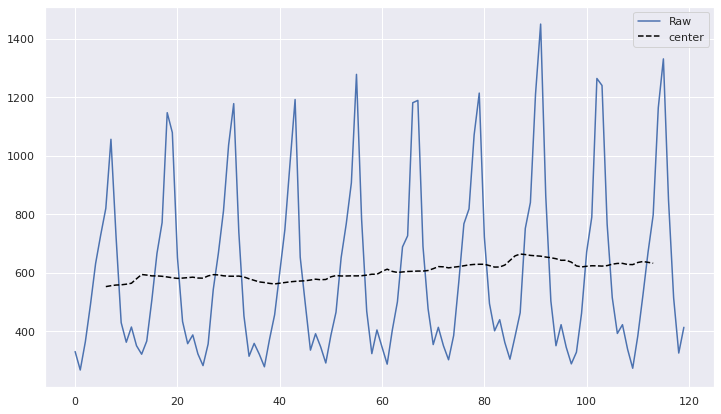

In [24]:
df_ma = df_ice["icecream_yen"].rolling(window=12).mean().shift(-6)
df_cma = df_ma.rolling(window=2).mean()

plt.figure(figsize=(12, 7))
plt.plot(df_ice["icecream_yen"], label="Raw")
plt.plot(df_cma, label="center", linestyle="dashed", c="black")
plt.legend()
plt.show()

### 季節変動の例

In [26]:
df_original_div_cma = df_ice["icecream_yen"] / df_cma

# 月ごとに加算を行う
original_div_cma = df_original_div_cma.values
n_index = np.zeros(12)
n_count = np.zeros(12, dtype="int")

for idx in range(len(original_div_cma) // 12):
    # 12ヶ月のデータを抽出
    count_original_div_cma = original_div_cma[idx * 12: (idx + 1) * 12]
    mask = count_original_div_cma != count_original_div_cma

    n_count += np.where(mask, 0, 1)
    n_index += np.where(mask, 0, count_original_div_cma)

n_index /= n_count
n_index = n_index / n_index.sum() * 1200

In [27]:
tiled_n_index = np.tile(n_index, len(original_div_cma) // 12)
df_adjusted_series = df_ice["icecream_yen"] / tiled_n_index * 100

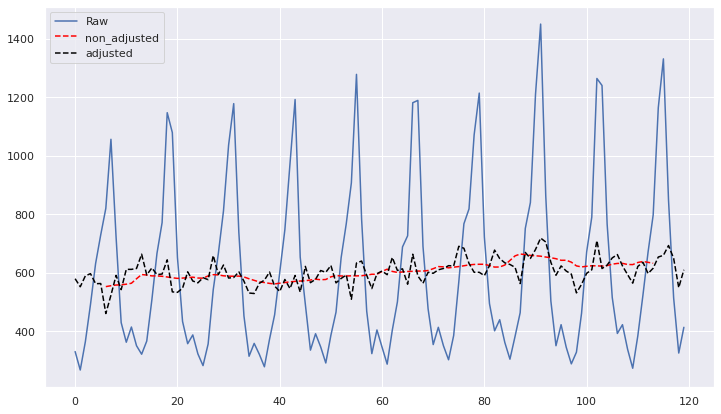

In [32]:
# 季節調整済み系列のプロット
plt.figure(figsize=(12, 7))
plt.plot(df_ice["icecream_yen"], label="Raw")
plt.plot(df_cma, label="non_adjusted", linestyle="dashed", c="red")
plt.plot(df_adjusted_series, label="adjusted", linestyle="dashed", c="black")
plt.legend()
plt.show()

### 移動平均乖離率

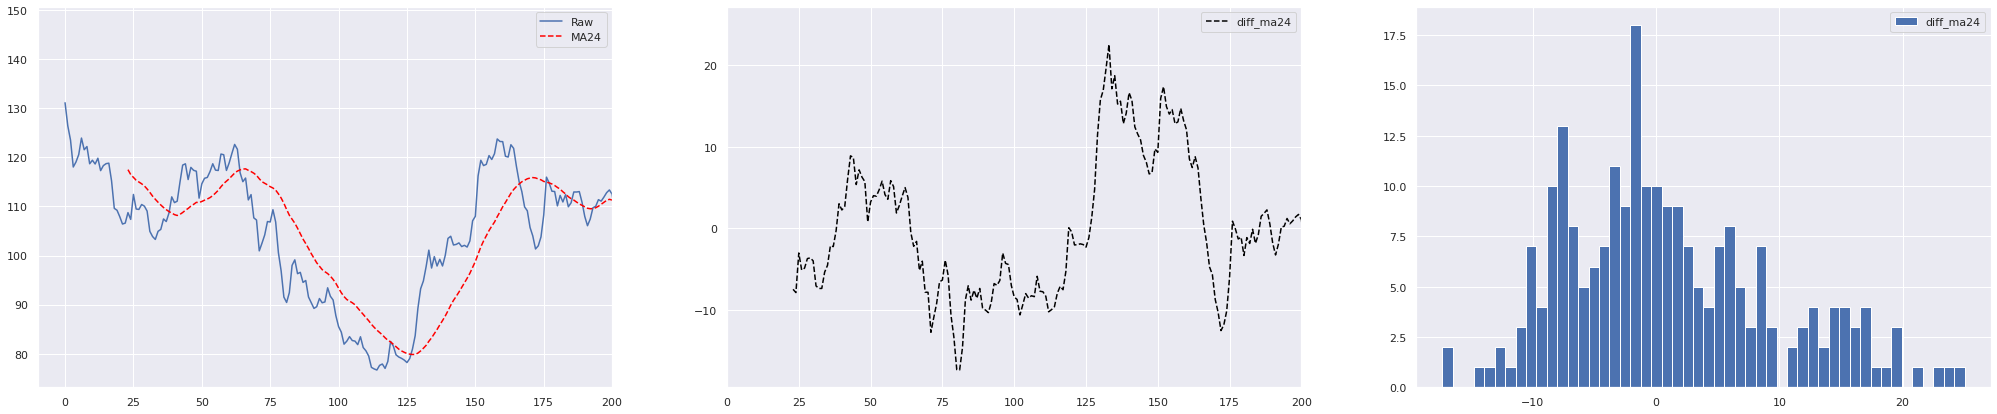

In [55]:
ma24 = df_historical["USD"].rolling(24).mean()
diff_ma24 = (df_historical["USD"] - ma24) / ma24 * 100

fig, ax = plt.subplots(1, 3, figsize=(35, 7))
ax[0].plot(df_historical["USD"], label="Raw")
ax[0].plot(ma24, label="MA24", linestyle="dashed", c="red")
ax[0].set_xlim(-10, 200)
ax[0].legend()

ax[1].plot(diff_ma24, label="diff_ma24", linestyle="dashed", c="black")
ax[1].set_xlim(0, 200)
ax[1].legend()

ax[2].hist(diff_ma24, bins=50, label="diff_ma24")
ax[2].legend()

plt.show()

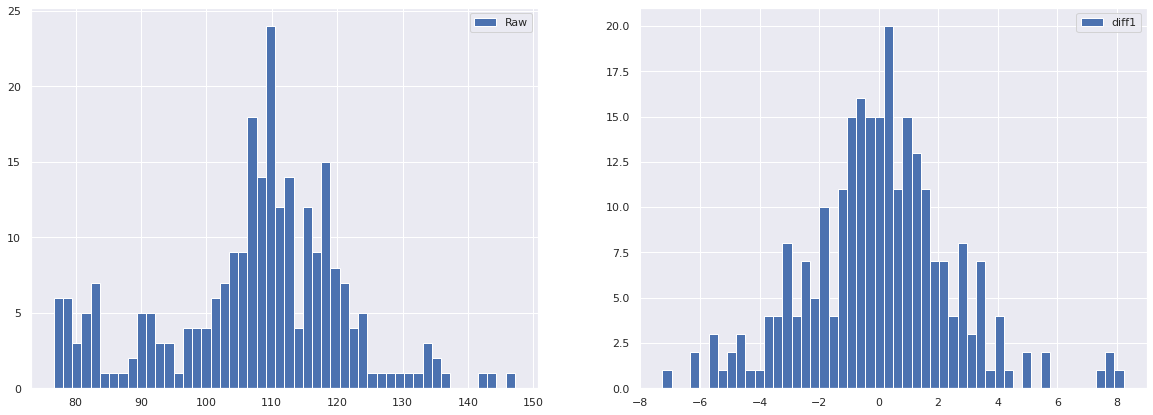

ShapiroResult(statistic=0.9602670669555664, pvalue=1.9001352029590635e-06)
ShapiroResult(statistic=0.9833338856697083, pvalue=0.004786995239555836)


In [56]:
# 正規性の検定
# Shapiro-Wilk検定では、帰無仮説が「データは正規分布に従う」なので、p値が小さいほど正規分布に従わない。（高いと従う）
import scipy.stats as stats

df_diff1 = df_historical["USD"].diff().dropna()

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].hist(df_historical["USD"], bins=50, label="Raw")
ax[0].legend()

ax[1].hist(df_diff1, bins=50, label="diff1")
ax[1].legend()
plt.show()

print(stats.shapiro(df_historical["USD"]))
print(stats.shapiro(df_diff1))

### 時間依存性の発見（自己相関の検定）

In [58]:
import io
import requests
import statsmodels.api as sm

# 月ごとのデータを取得
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
df_content = pd.read_csv(io.StringIO(stream.decode('utf-8')))
df_content.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [61]:
# 自己相関
p_acf = sm.tsa.stattools.acf(df_content["#Passengers"])

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


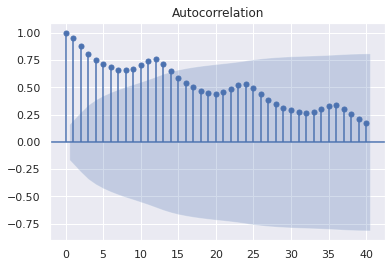

In [72]:
plot_acfs = sm.graphics.tsa.plot_acf(df_content["#Passengers"], lags=40)

In [67]:
# 偏自己相関
p_pacf = sm.tsa.stattools.pacf(df_content["#Passengers"], method="ols", nlags=40)
p_pacf

array([ 1.        ,  0.95893198, -0.32983096,  0.2018249 ,  0.14500798,
        0.25848232, -0.02690283,  0.20433019,  0.15607896,  0.56860841,
        0.29256358,  0.8402143 ,  0.61268285, -0.66597616, -0.38463943,
        0.0787466 , -0.02663483, -0.05805221, -0.04350748,  0.27732556,
       -0.04046447,  0.13739883,  0.3859958 ,  0.24203808, -0.04912986,
       -0.19599778, -0.15443575,  0.04484465,  0.18371541, -0.0906113 ,
       -0.06202938,  0.34827092,  0.09899499, -0.08396793,  0.36328898,
       -0.17956662,  0.15839435,  0.06376775, -0.27503705,  0.2707607 ,
        0.32002003])

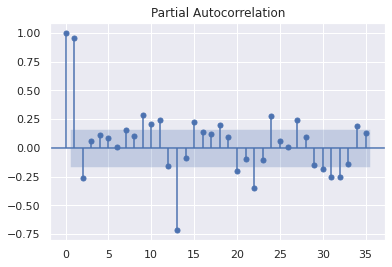

In [71]:
plots = sm.graphics.tsa.plot_pacf(df_content["#Passengers"], lags=35)